### Main Notebook for visualisation 

Setup for required libraries:

In [1]:
%pip install numpy pandas matplotlib keras scikit-learn tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Importing data for DNN training (using Pandas):

In [2]:
import pandas as pd
import numpy as np

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'


df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)



In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, LSTM
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.random.set_seed(7)

2023-10-20 11:50:57.885709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Doing it for one Node as i cant get it working for more than 1 atm:

In [68]:
vel_data = df_vel.iloc[:, 1]
idle_data = df_idle.iloc[:, 1]
vuln_data = df_vuln.iloc[:, 1]
dist_data = df_dist.iloc[:, 1]

df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan)
df.iloc[df.iloc[:, 1] < 0, 1] = np.nan


# Drop rows with NaN values
df = df.dropna()

threshold = 50

df.iloc[df.iloc[:, -1] < threshold, -1] = 0
df.iloc[df.iloc[:, -1] >= threshold, -1] = 1
df



,1,1,1,1
29,0.442088,0.1,0.208419,1.0
30,0.746647,1.1,0.341967,1.0
31,-0.506924,2.1,0.155407,1.0
32,-0.639698,3.1,0.058275,1.0
33,-0.371207,4.1,0.038649,1.0
...,...,...,...,...
21471,0.297613,61.5,0.031957,0.0
21472,0.361728,62.5,0.038487,0.0
21473,0.560482,63.5,0.053068,0.0
21474,0.684252,64.5,0.081471,0.0


Train and test split:

In [69]:
dataset = df.to_numpy()
# dataset[2] = scaler.fit_transform(dataset[2])


# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
df.iloc[:,3].value_counts()
# df.iloc[:,75:100]
# df.iloc[:,50:75]




15012 6435


1
0.0    20427
1.0     1020
Name: count, dtype: int64

In [70]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:-1]
		dataX.append(a)
		dataY.append(dataset[i + look_back, -1])
	return np.array(dataX), np.array(dataY)

look_back = 50

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainY)

[0. 0. 0. ... 0. 0. 0.]


In [71]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[-1]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[-1]))
trainX.shape

(14961, 50, 3)

In [72]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, trainX.shape[-1])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
14961/14961 - 87s - loss: 0.1995 - accuracy: 0.9478 - 87s/epoch - 6ms/step
Epoch 2/10
14961/14961 - 89s - loss: 0.1896 - accuracy: 0.9524 - 89s/epoch - 6ms/step
Epoch 3/10
14961/14961 - 94s - loss: 0.1860 - accuracy: 0.9524 - 94s/epoch - 6ms/step
Epoch 4/10
14961/14961 - 92s - loss: 0.1847 - accuracy: 0.9524 - 92s/epoch - 6ms/step
Epoch 5/10
14961/14961 - 88s - loss: 0.1870 - accuracy: 0.9524 - 88s/epoch - 6ms/step
Epoch 6/10
14961/14961 - 94s - loss: 0.1836 - accuracy: 0.9524 - 94s/epoch - 6ms/step
Epoch 7/10
14961/14961 - 95s - loss: 0.1822 - accuracy: 0.9524 - 95s/epoch - 6ms/step
Epoch 8/10
14961/14961 - 91s - loss: 0.1805 - accuracy: 0.9524 - 91s/epoch - 6ms/step
Epoch 9/10
14961/14961 - 90s - loss: 0.1791 - accuracy: 0.9524 - 90s/epoch - 6ms/step
Epoch 10/10
14961/14961 - 94s - loss: 0.1781 - accuracy: 0.9524 - 94s/epoch - 6ms/step


In [115]:

trainPredict = model.predict(trainX).T[0]
testPredict = model.predict(testX).T[0]
print(trainPredict.max())
print(trainY)
# Apply a threshold to convert the probabilities to binary predictions (0 or 1)
threshold = 0.12 # Adjust the threshold if needed
trainPredict_binary = (trainPredict > threshold).astype(int)
testPredict_binary = (testPredict > threshold).astype(int)
print(trainPredict_binary)
print(trainY)


200/200 [==============================] - 1s 4ms/step
0.26301485
[0. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [116]:
test = pd.DataFrame(trainPredict_binary)
check = pd.concat([test,pd.DataFrame(trainY)],axis=1)
test.value_counts()
mask = check.iloc[:,0] == 1
attacks = check[mask]


# 0 represents the number of failed attacks by adversary
attacks.iloc[:,1].value_counts()


0
0.0    530
1.0     99
Name: count, dtype: int64

In [113]:
from sklearn.metrics import accuracy_score, f1_score

# Compute accuracy and F1 score
train_accuracy = accuracy_score(trainY, trainPredict_binary)
test_accuracy = accuracy_score(testY, testPredict_binary)

train_f1_score = f1_score(trainY, trainPredict_binary)
test_f1_score = f1_score(testY, testPredict_binary)

print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

print('Train F1 Score:', train_f1_score)
print('Test F1 Score:', test_f1_score)

Train Accuracy: 0.9503375442817994
Test Accuracy: 0.9505012531328321
Train F1 Score: 0.05108556832694764
Test F1 Score: 0.0125


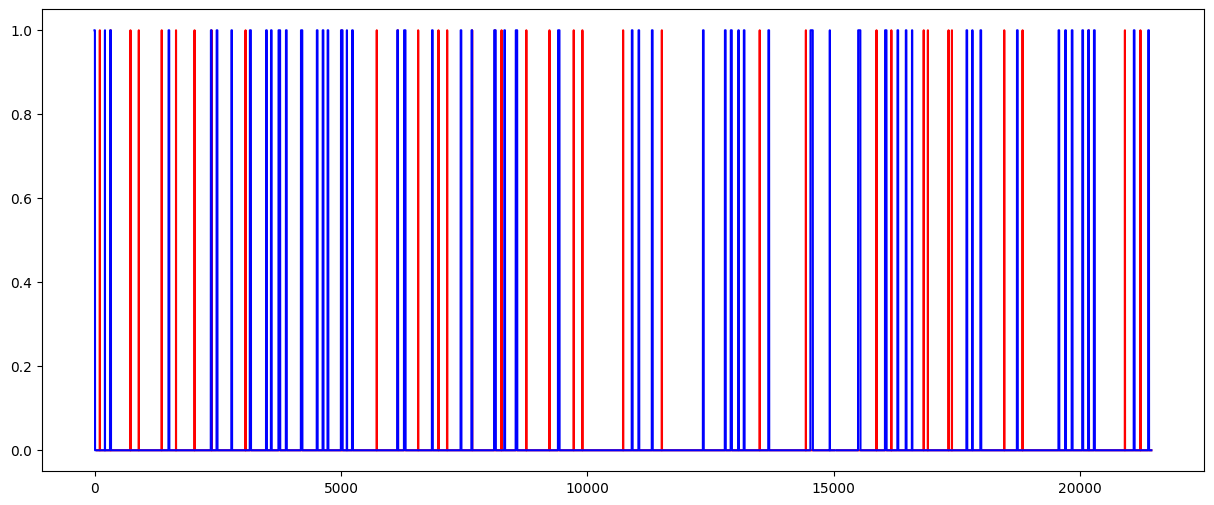

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,2])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict_binary)+look_back] = trainPredict_binary
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,2])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict_binary)+(look_back*2)+1:len(dataset[:,2])-1] = testPredict_binary
# plot baseline and predictions
plt.plot(trainPredictPlot,'r')
plt.plot(testPredictPlot,'r')
plt.plot(dataset[:,-1],'b')
plt.show()